In [29]:
# Step: Load Required Libraries
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
# Step: Load the Trained Model
model_path = '../models/kline_price_model.keras'  # Update if needed
model = tf.keras.models.load_model(model_path)

# Load the scalers
scaler_price = joblib.load('../models/scaler_price.pkl')
scaler_volume = joblib.load('../models/scaler_volume.pkl')
scaler_indicator = joblib.load('../models/scaler_indicator.pkl')
scaler_target = joblib.load('../models/scaler_target.pkl')

print('Model successfully loaded!')

Model successfully loaded!


In [31]:
# Step: Load and Preprocess New Kline Data
def load_new_kline_data(directory='../data/kline/1m'):
    kline_df = pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            temp_df = pd.read_csv(file_path)
            kline_df = pd.concat([kline_df, temp_df], ignore_index=True)

    return kline_df

# Load new Kline data
new_kline_df = load_new_kline_data()

# Convert startTime to datetime format
new_kline_df['startTime'] = pd.to_datetime(new_kline_df['startTime'], unit='ms')

# Ensure numeric columns are properly formatted
numeric_cols = ['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']
new_kline_df[numeric_cols] = new_kline_df[numeric_cols].astype(float)

# Feature Engineering
new_kline_df['price_change'] = new_kline_df['closePrice'].shift(-1) - new_kline_df['closePrice']
new_kline_df['price_range'] = new_kline_df['highPrice'] - new_kline_df['lowPrice']
new_kline_df['SMA_5'] = new_kline_df['closePrice'].rolling(window=5).mean()
new_kline_df['SMA_15'] = new_kline_df['closePrice'].rolling(window=15).mean()
new_kline_df['EMA_5'] = new_kline_df['closePrice'].ewm(span=5, adjust=False).mean()
new_kline_df['EMA_15'] = new_kline_df['closePrice'].ewm(span=15, adjust=False).mean()
new_kline_df['volume_change'] = new_kline_df['volume'].pct_change()
new_kline_df['turnover_change'] = new_kline_df['turnover'].pct_change()

# Drop missing values
new_kline_df = new_kline_df.dropna()

# Normalize price-related columns
new_kline_df[['openPrice', 'highPrice', 'lowPrice', 'closePrice']] = scaler_price.fit_transform(
    new_kline_df[['openPrice', 'highPrice', 'lowPrice', 'closePrice']]
)

# Normalize other columns as well if needed
new_kline_df[['volume', 'turnover', 'volume_change', 'turnover_change']] = scaler_volume.fit_transform(
    new_kline_df[['volume', 'turnover', 'volume_change', 'turnover_change']]
)

new_kline_df[['SMA_5', 'SMA_15', 'EMA_5', 'EMA_15']] = scaler_indicator.fit_transform(
    new_kline_df[['SMA_5', 'SMA_15', 'EMA_5', 'EMA_15']]
)

# Prepare features for prediction
X_new = new_kline_df[['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover', 'SMA_5', 'SMA_15', 'EMA_5', 'EMA_15', 'volume_change', 'turnover_change']]
y_actual = new_kline_df['price_change']
y_actual_normalized = scaler_target.fit_transform(y_actual.values.reshape(-1, 1))

In [32]:
# Step: Make Predictions
y_pred = model.predict(X_new)
y_pred_actual = scaler_target.inverse_transform(y_pred)

315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [33]:
# Step: Model Evaluation
mse = mean_squared_error(y_actual, y_pred_actual)
mae = mean_absolute_error(y_actual, y_pred_actual)

print(f'Model Evaluation Metrics:')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Model Evaluation Metrics:
Mean Squared Error (MSE): 3834.077150739958
Mean Absolute Error (MAE): 44.712512163148205


In [34]:
# Step: Calc directional accuracy function

def directional_accuracy(y_true, y_pred):
  # Get direction of actual (positive/negative) price changes
  actual_direction = np.sign(y_true)

  # Get direction of predicted (positive/negative) price changes
  predicted_direction = np.sign(y_pred)

  # Check for opposite direction: actual and predicted should have opposite signs
  mispredictions = (actual_direction != predicted_direction).sum()

  # Calculate the directional accuracy
  total_predictions = len(y_true)
  directional_accuracy = 1 - (mispredictions / total_predictions)

  return directional_accuracy, mispredictions, total_predictions

dir_accuracy, mispredictions, total = directional_accuracy(y_actual, y_pred_actual.flatten())

print(f'Directional Accuracy: {dir_accuracy * 100:.2f}%')
print(f'Number of Mispredictions: {mispredictions} out of {total} predictions')

Directional Accuracy: 48.67%
Number of Mispredictions: 5166 out of 10065 predictions


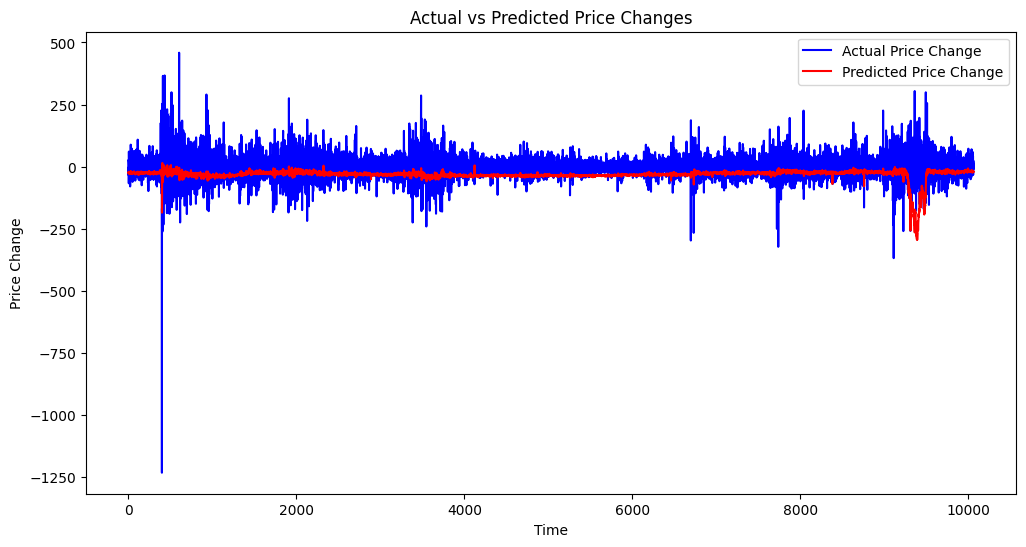

In [35]:
# Step: Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_actual.values, label='Actual Price Change', color='blue')
plt.plot(y_pred_actual, label='Predicted Price Change', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.title('Actual vs Predicted Price Changes')
plt.show()

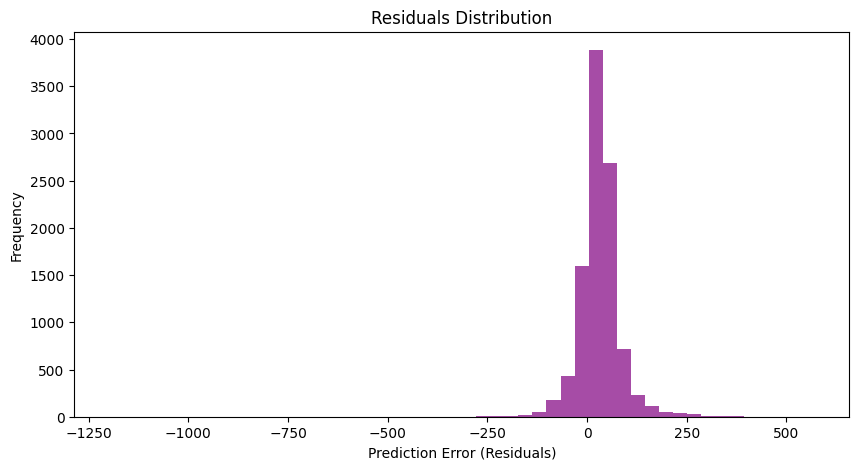

In [36]:
# Step: Error Analysis (Residual Plot)
residuals = y_actual.values - y_pred_actual.flatten()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()